<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Titanic---Who-is-going-to-survive-?---classification" data-toc-modified-id="Titanic---Who-is-going-to-survive-?---classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Titanic - Who is going to survive ? - classification</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Innitial-accuracy" data-toc-modified-id="Innitial-accuracy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Innitial accuracy</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Embarked,-Sex,-Name_len" data-toc-modified-id="Embarked,-Sex,-Name_len-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Embarked, Sex, Name_len</a></span></li><li><span><a href="#Coorelation" data-toc-modified-id="Coorelation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Coorelation</a></span></li><li><span><a href="#Title" data-toc-modified-id="Title-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Title</a></span></li><li><span><a href="#Family" data-toc-modified-id="Family-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Family</a></span></li><li><span><a href="#Age-groups" data-toc-modified-id="Age-groups-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Age groups</a></span></li><li><span><a href="#Ensemble-of-models" data-toc-modified-id="Ensemble-of-models-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Ensemble of models</a></span></li></ul></li><li><span><a href="#Hyperparameters-tuning" data-toc-modified-id="Hyperparameters-tuning-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Hyperparameters tuning</a></span></li><li><span><a href="#Kaggle-submission" data-toc-modified-id="Kaggle-submission-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Kaggle submission</a></span></li></ul></div>

# Titanic - Who is going to survive ? - classification

Greetings welcome to my Titanic projects in which I am going to make a classifier which can tell us who was most likely to survive on Titanic !  
With my classifier if you could turn back the time, you would be able to warn the least likely to survive.

If you are interested in my methodology, feel free to go step by step or cell by cell 😉 through the notebook.  
For final results and conclusions go to the **Kaggle submission** section.

Explanation of each column in the dataframe can be found here https://www.kaggle.com/c/titanic/data

# Imports

In [180]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from IPython.display import clear_output
from time import sleep

pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_row',500)
pd.set_option('display.max_columns', 50)


from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split


from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import scikitplot as skplt

import xgboost as xgb
import lightgbm as lgbm
import catboost as ctb

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [181]:
def plt_learn_curve(cls_model,X,y,model_args,scoring='accuracy', cv=5):
    model = cls_model(**model_args)
    model.fit(X, y)
    title=f'Learning Curve. {cls_model.__name__}: {model_args}'
    skplt.estimators.plot_learning_curve(model, X, y, title=title,figsize=(15, 5), cv=cv, scoring=scoring);

def plt_confusion_matrix(cls_model,X,y,model_args, cv=5):
    y_pred = cross_val_predict(cls_model(**model_args), X, y, cv=cv)
    title=f'Confusion matrix {cls_model.__name__}: {model_args}'
    skplt.metrics.plot_confusion_matrix(y, y_pred, title=title, normalize=True, figsize=(10 ,10))

def plt_feats_importance(cls_model,X,y,model_args,feats, cv=5):
    model = cls_model(**model_args)
    model.fit(X, y)
    title=f'Feature Importance {cls_model.__name__}: {model_args}'
    skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));
    
def fit_cv_vis(cls_model,X,y,model_args,feats,scoring='accuracy', cv=5, plt_learn_curve_b=True, plt_confusion_matrix_b=True, plt_feats_importance_b=True):
    scores = cross_val_score(cls_model(**model_args), X, y, cv=cv, scoring=scoring);
    print(f'{cls_model.__name__} mean = {np.round(np.mean(scores)*100, 2)} st_dev = {np.round(np.std(scores), 2)} scores = {scores}')
    
    if plt_learn_curve_b:
        plt_learn_curve(cls_model,X,y,model_args,scoring=scoring, cv=5)
    if plt_confusion_matrix_b:
        plt_confusion_matrix(cls_model,X,y,model_args, cv=5)
    if plt_feats_importance_b:
        if hasattr(cls_model, 'feature_importances_'):
            plt_feats_importance(cls_model,X,y,model_args,feats, cv=5)
    return {cls_model.__name__ : scores}

def eval_models(X_train,X_test,cv,feats,plt_learn_curve_b=False, plt_confusion_matrix_b=False, plt_feats_importance_b=False):
    scores = []
    for model,model_args in models:
        scores.append(fit_cv_vis(model, X_train, X_test, model_args, cv=cv,feats=feats,
                                 plt_learn_curve_b=plt_learn_curve_b, 
                                 plt_confusion_matrix_b=plt_confusion_matrix_b, 
                                 plt_feats_importance_b=plt_feats_importance_b))
    return scores

In [182]:
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/train.csv
../input/gender_submission.csv
../input/test.csv


In [183]:
train_df = pd.read_csv("../input/train.csv")
X_test = pd.read_csv("../input/test.csv")
kaggle_submission_exmp = pd.read_csv("../input/gender_submission.csv")

# Innitial accuracy

Let's evalutate how well can we classify the titanic survivors based only on the innitial numerical data.  
But first it is worth to check for missing values and data types of the columnes

In [184]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
236,237,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.00,NaN,S
695,696,0,2,"Chapman, Mr. Charles Henry",male,52.0,0,0,248731,13.50,NaN,S
649,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.55,NaN,S
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.75,NaN,Q
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.00,B22,S


In [185]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [186]:
numerical_cols = [column for column in train_df.columns 
                  if train_df[column].dtype != np.dtype(object) and column != ('Survived')]
X_train = train_df[numerical_cols].fillna(-1)
y_train = train_df['Survived']

Transformation yielded following training data frame 

In [187]:
X_train

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,887,2,27.0,0,0,13.0000
887,888,1,19.0,0,0,30.0000
888,889,3,-1.0,1,2,23.4500
889,890,1,26.0,0,0,30.0000


Lets establish innitial accuracy score, that i will try to increase

In [188]:
models = [(DummyClassifier,{}),
          (LogisticRegression,{'solver': 'lbfgs','max_iter':10000}),
          (RandomForestClassifier,{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}),
          (ExtraTreesClassifier,{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}),
          (xgb.XGBClassifier,{'colsample_bytree' : 0.5, 'learning_rate' : 0.0001, 'max_depth' : 10, 'alpha' : 12,
                             'n_estimators' : 11, 'use_label_encoder': False,'eval_metric' :'logloss'}),
          (ctb.CatBoostClassifier, {'iterations' :100,'depth' :10, 'learning_rate' :0.0001, 'loss_function' :'Logloss','verbose' : False}),
          (lgbm.LGBMClassifier, {'n_estimators':11, 'max_depth':10,'learning_rate' :0.0001})
         ]

In [189]:
scores = eval_models(X_train.values,train_df['Survived'].values,cv=5,feats=numerical_cols)

DummyClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]
LogisticRegression mean = 69.37 st_dev = 0.04 scores = [0.62011173 0.68539326 0.70786517 0.73033708 0.7247191 ]
RandomForestClassifier mean = 71.62 st_dev = 0.06 scores = [0.62569832 0.68539326 0.73595506 0.78651685 0.74719101]
ExtraTreesClassifier mean = 72.06 st_dev = 0.05 scores = [0.63128492 0.71910112 0.7247191  0.7752809  0.75280899]
XGBClassifier mean = 70.38 st_dev = 0.05 scores = [0.62011173 0.67977528 0.71348315 0.76404494 0.74157303]
CatBoostClassifier mean = 70.16 st_dev = 0.06 scores = [0.60335196 0.69101124 0.70224719 0.75280899 0.75842697]
LGBMClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]


1. Without any feature engineering with gradient boosting we get **70% accuracy** of classification now lets look at the data, and try to increase the accuracy score.  
2. Firstly I am going to temporarly merge X_train and X_test, so that i do not have to repeat all the preprocessing on both of the data frames seperately

In [190]:
X_test_min_id = min(X_test['PassengerId'].values) #saving test ids for easy split of dfs
train_test_df = train_df.merge(X_test,how='outer') #merging dfs
numerical_cols = [column for column in train_df.columns 
                  if train_df[column].dtype != np.dtype(object) and column != ('Survived')]
X_train = train_test_df[numerical_cols].fillna(-1)
y_train = train_df['Survived']

The classes are imbalanced this might require some work later 

In [191]:
print(train_test_df['Survived'].value_counts())
dead  = train_test_df['Survived'].value_counts()[0]
alive = train_test_df['Survived'].value_counts()[1]
print(f'{round(alive/(dead+alive)*100,2)}% survived')

0.0    549
1.0    342
Name: Survived, dtype: int64
38.38% survived


# Feature Engineering

## Embarked, Sex, Name_len

Let's test weather sex influenced survival on Titanic.

In [192]:
female_surviving = len(train_test_df[(train_test_df['Sex'] == 'female') & train_test_df['Survived'] == 1])
female_num =  len(train_test_df[(train_test_df['Sex'] == 'female')])
male_surviving = len(train_test_df[(train_test_df['Sex'] == 'male') & train_test_df['Survived'] == 1])
male_num =len(train_test_df[(train_test_df['Sex'] == 'male')])
fs_ratio = female_surviving/female_num
ms_ratio = male_surviving/male_num
print(f'Female survival ratio {round(fs_ratio,2)}')
print(f'Male survival ratio {round(ms_ratio,2)}')

Female survival ratio 0.5
Male survival ratio 0.13


I think sex might have been one of the factors influencing survival, it should get factorized and tested along with other properties

In [193]:
train_test_df['PassengerId'] = train_test_df['PassengerId']
train_test_df['Sex_cat'] = train_test_df['Sex'].factorize()[0]
train_test_df['Embarked_cat'] = train_test_df['Embarked'].factorize()[0] # I suspect that different socio-economic groups may depart from different ports which could influence survival
train_test_df['Name_len_cat'] = train_test_df['Name'].map(lambda x: len(x)) #often celebrities have longer name property because of their pseudonym besides the name

In [194]:
train_test_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,Embarked_cat,Name_len_cat
640,641,0.0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S,0,0,22
184,185,1.0,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S,1,0,35
1209,1210,NaN,3,"Jonsson, Mr. Nils Hilding",male,27.0,0,0,350408,7.8542,NaN,S,0,0,25
724,725,1.0,1,"Chambers, Mr. Norman Campbell",male,27.0,1,0,113806,53.1000,E8,S,0,0,29
280,281,0.0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q,0,2,16


In [195]:
def get_cat_feats(df,id_range,to_exclude = ['Survived']):
    start,stop = id_range
    numerical_cols = [column for column in df.columns 
                  if df[column].dtype != np.dtype(object) and column != ('Survived')]    
    in_id_range = ((df['PassengerId']>=start) & (df['PassengerId']<stop))
    
    X_train = df[in_id_range][numerical_cols].fillna(-1)
    y_train = df[in_id_range]['Survived']
    return X_train,y_train
def add_feat(X_train,novel_feats,in_id_range):
    X_train_merged = X_train.merge(novel_feats,how='inner')
    return X_train_merged[in_id_range] #additionally to make sure we don't use X_test

In [196]:
X_train,y_train = get_cat_feats(train_test_df,id_range=(0,X_test_min_id))
#X_train_merged = add_feat( X_train,novel_feats,id_range=(0,X_test_min_id))

Using additional features the models exceeded 80 % accuracy, it seems to be influenced mostly by Sex, Fare, and Psclassm also name length (posible celebrity( category.  
Interrestingly gradient boosting methods show comparable score to simpler models e.g. logistic regression in the current problem.

DummyClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]
LogisticRegression mean = 79.35 st_dev = 0.02 scores = [0.81564246 0.78089888 0.80898876 0.76404494 0.79775281]
RandomForestClassifier mean = 80.47 st_dev = 0.02 scores = [0.77653631 0.82022472 0.83146067 0.78089888 0.81460674]
ExtraTreesClassifier mean = 80.92 st_dev = 0.01 scores = [0.82122905 0.80898876 0.80337079 0.79213483 0.82022472]
XGBClassifier mean = 77.56 st_dev = 0.05 scores = [0.68156425 0.80337079 0.8258427  0.76966292 0.79775281]
CatBoostClassifier mean = 80.25 st_dev = 0.01 scores = [0.81564246 0.80337079 0.80898876 0.7752809  0.80898876]
LGBMClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]


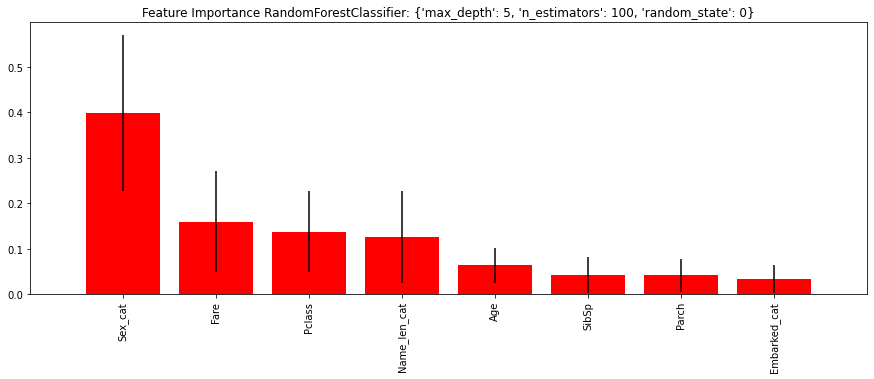

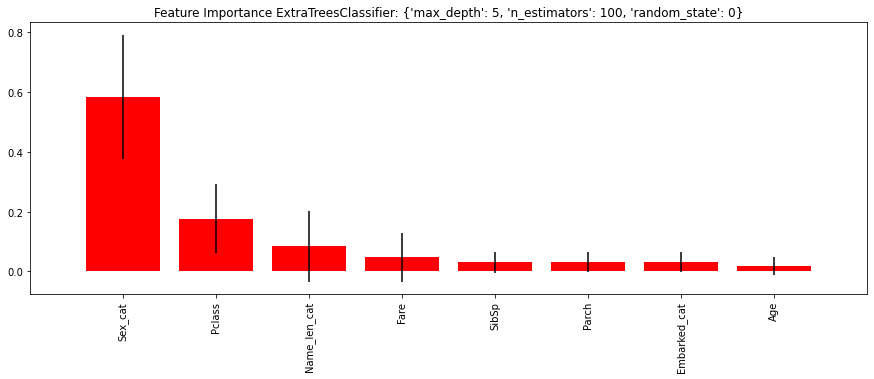

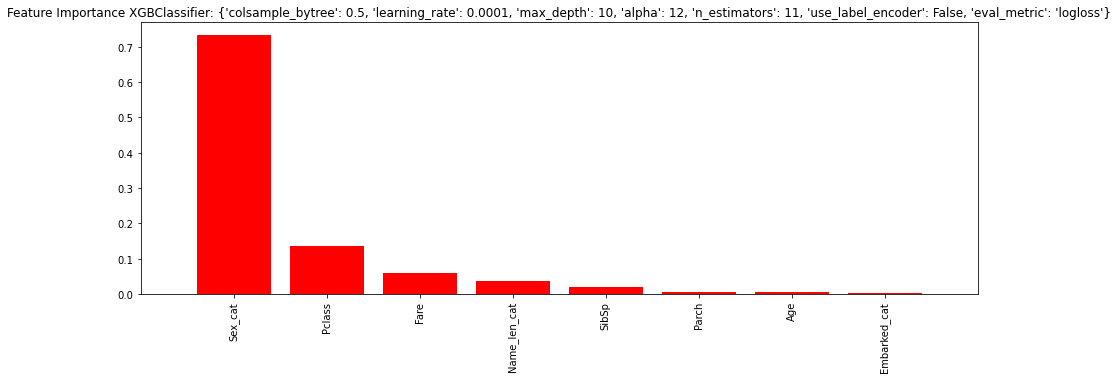

Exception ignored in: <function PtyProcess.__del__ at 0x7f2f97fe5560>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/ptyprocess/ptyprocess.py", line 377, in __del__
    if not self.closed:
AttributeError: 'PtyProcess' object has no attribute 'closed'


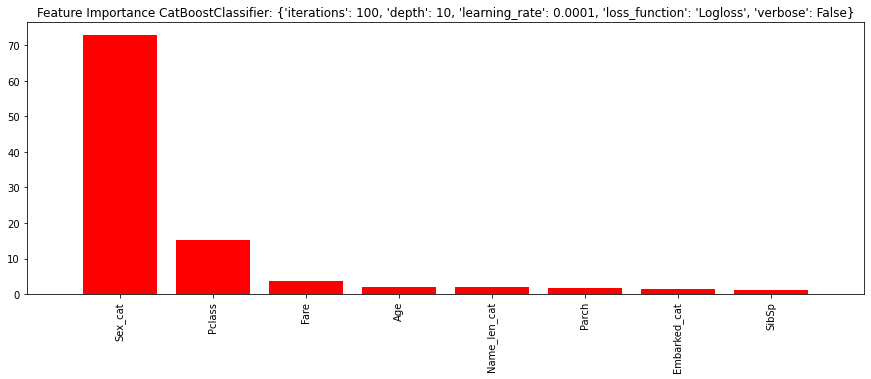

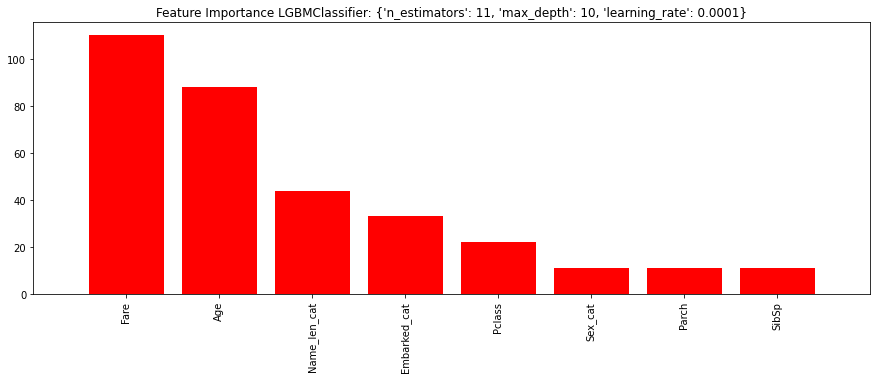

In [197]:
scores = eval_models(X_train.drop(['PassengerId'],axis=1).values,y_train.values,cv=5,
                     feats=X_train.drop(['PassengerId'],axis=1).columns,plt_feats_importance_b=True) #droping ids not to treat it as feature

## Coorelation

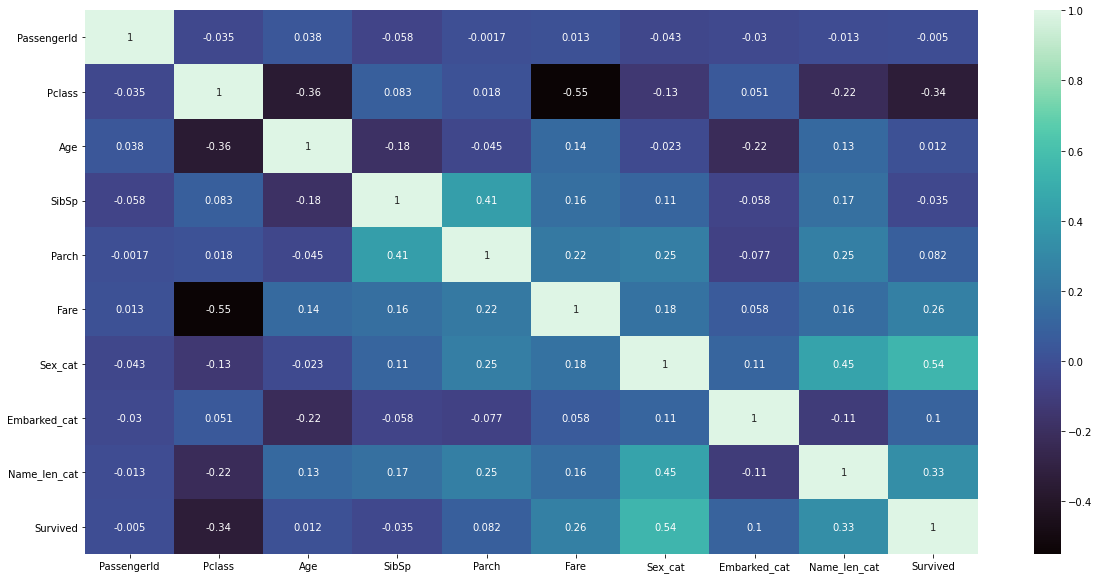

In [198]:
fig = plt.figure(figsize=(20,10))
sns.heatmap(X_train.join(y_train).corr(),cmap='mako',annot=True);

## Title

Name length feature (Name_len_cat) is in the top 3 in the correlation matrix, maybe it is worth to process it a bit more.  
There are several different titles in the Name category.

In [199]:
train_test_df[['Name']]

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)"
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
1304,"Spector, Mr. Woolf"
1305,"Oliva y Ocana, Dona. Fermina"
1306,"Saether, Mr. Simon Sivertsen"
1307,"Ware, Mr. Frederick"


In [200]:
title_series = train_test_df['Name'].map(lambda x: x.split(',')[1].split()[0][:-1])
title_counts = title_series.value_counts()
title_counts

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Mme           1
Dona          1
Jonkheer      1
Lady          1
Capt          1
th            1
Don           1
Sir           1
Name: Name, dtype: int64

In [201]:
top_titles = list(title_counts.head(6).keys())
titles_dict = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))

train_test_df_copy = train_test_df.copy()

train_test_df_copy['title_norm'] = title_series.map(titles_dict)
train_test_df_copy['title_norm'].value_counts()
train_test_df_copy['title_cat'] = train_test_df_copy['title_norm'].factorize()[0]
del train_test_df_copy['title_norm']
X_train,y_train = get_cat_feats(train_test_df_copy,id_range=(0,X_test_min_id))

DummyClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]
LogisticRegression mean = 79.46 st_dev = 0.02 scores = [0.82122905 0.76966292 0.78651685 0.79775281 0.79775281]
RandomForestClassifier mean = 81.93 st_dev = 0.01 scores = [0.82681564 0.82022472 0.82022472 0.79775281 0.83146067]
ExtraTreesClassifier mean = 81.93 st_dev = 0.02 scores = [0.83240223 0.81460674 0.82022472 0.79213483 0.83707865]
XGBClassifier mean = 79.8 st_dev = 0.02 scores = [0.79329609 0.8258427  0.81460674 0.76966292 0.78651685]
CatBoostClassifier mean = 81.03 st_dev = 0.01 scores = [0.81005587 0.81460674 0.8258427  0.78651685 0.81460674]
LGBMClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]


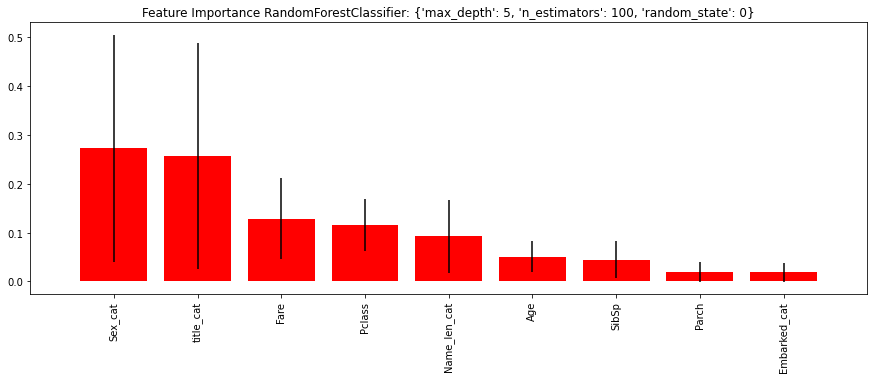

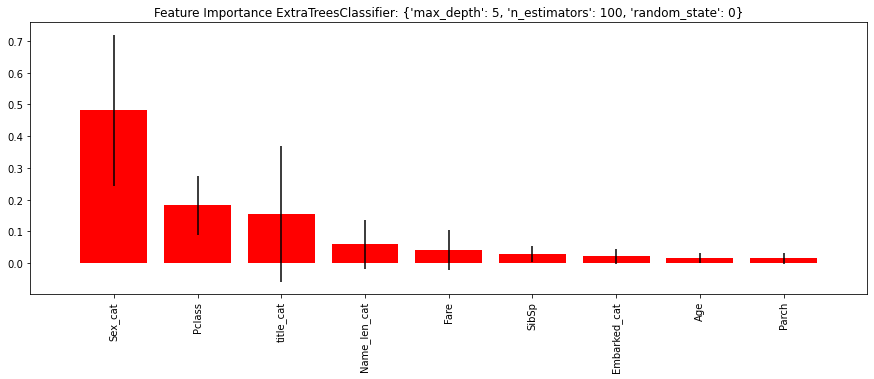

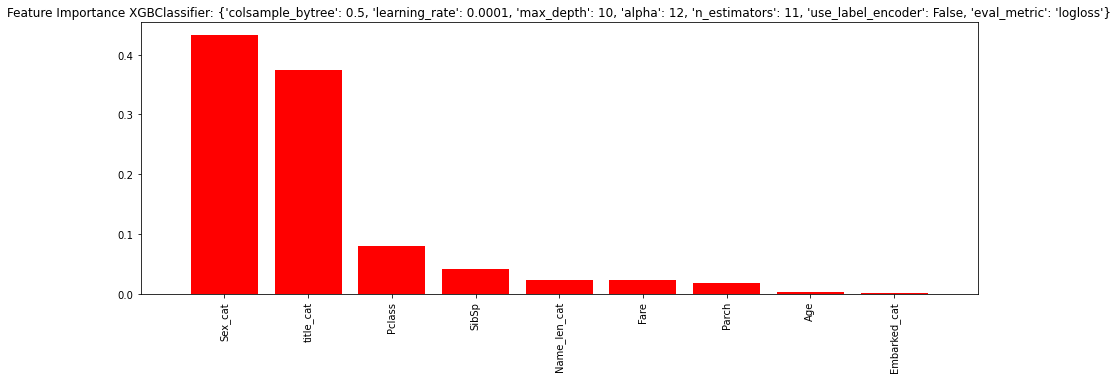

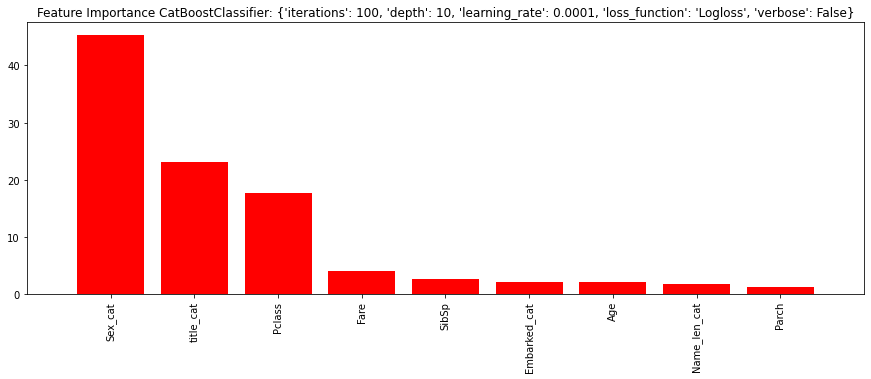

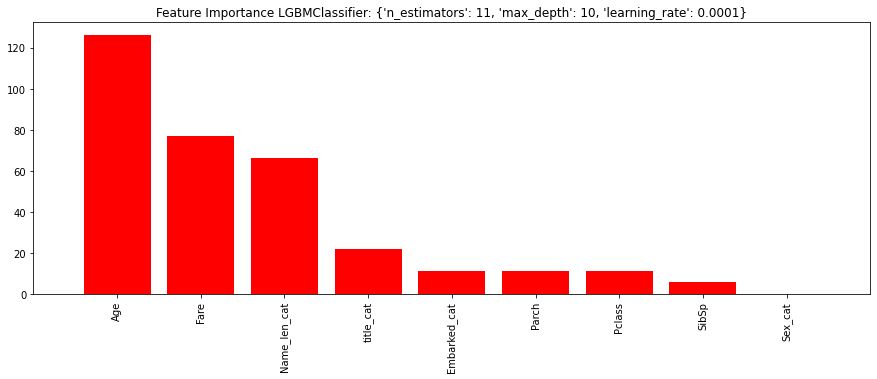

In [202]:
scores = eval_models(X_train.drop(['PassengerId'],axis=1).values,y_train.values,cv=5,
                     feats=X_train.drop(['PassengerId'],axis=1).columns,plt_feats_importance_b=True) #droping ids not to treat it as feature

New accuracy reached almost **82 %**, except for LGBM both baging and boosting models placed title as one of the top features.

In [203]:
train_test_df = train_test_df_copy.copy() # main df is train_test_df, i use its copied version to check weather new feat influence accuracy train_test_df_copy

In [204]:
train_test_df['Ticket']

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1304             A.5. 3236
1305              PC 17758
1306    SOTON/O.Q. 3101262
1307                359309
1308                  2668
Name: Ticket, Length: 1309, dtype: object

Separating symbols from numerical part in the ticket

In [205]:
def f(x):
    splited = x.split()
    if len(splited) > 1:
        try:
            int(splited[0].strip())
        except ValueError:
            return (splited[0].strip())
        
len(train_test_df[~train_test_df['Ticket'].map(lambda x: f(x)).isna()])

348

Most of the tickets don't have the letter part so i will only use ticket number right know

In [206]:
train_test_df_copy['ticket_no'] = train_test_df['Ticket'].str.extract('(\d+)').fillna(-1).astype(int)
X_train,y_train = get_cat_feats(train_test_df_copy,id_range=(0,X_test_min_id))
scores = eval_models(X_train.drop(['PassengerId'],axis=1).values,y_train.values,cv=5,
                     feats=X_train.drop(['PassengerId'],axis=1).columns) #droping ids not to treat it as feature

DummyClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]
LogisticRegression mean = 66.56 st_dev = 0.08 scores = [0.59776536 0.61235955 0.62921348 0.68539326 0.80337079]
RandomForestClassifier mean = 81.82 st_dev = 0.02 scores = [0.82681564 0.80898876 0.82022472 0.79213483 0.84269663]
ExtraTreesClassifier mean = 81.37 st_dev = 0.01 scores = [0.81564246 0.8258427  0.81460674 0.78651685 0.8258427 ]
XGBClassifier mean = 77.78 st_dev = 0.02 scores = [0.75977654 0.80337079 0.78651685 0.75280899 0.78651685]
CatBoostClassifier mean = 81.26 st_dev = 0.02 scores = [0.82681564 0.81460674 0.8258427  0.78089888 0.81460674]
LGBMClassifier mean = 61.62 st_dev = 0.0 scores = [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]


Usege of ticket number caused the score to decrease that is why i am not going to use it in main training data frame

In [207]:
del train_test_df_copy['ticket_no']

## Family

Lets drop two of the wost classifiers for this problem Dummy and LGBM

In [208]:
models = [(LogisticRegression,{'solver': 'lbfgs','max_iter':10000}),
          (RandomForestClassifier,{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}),
          (ExtraTreesClassifier,{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}),
          (xgb.XGBClassifier,{'colsample_bytree' : 0.5, 'learning_rate' : 0.0001, 'max_depth' : 10, 'alpha' : 12,
                             'n_estimators' : 11, 'use_label_encoder': False,'eval_metric' :'logloss'}),
          (ctb.CatBoostClassifier, {'iterations' :100,'depth' :10, 'learning_rate' :0.0001, 'loss_function' :'Logloss','verbose' : False}),
         ]

With three novel features accuracy increase to more than 83 %

In [209]:
train_test_df_copy['family_size']   = train_test_df['SibSp'] + train_test_df['Parch'] + 1
train_test_df_copy['family_small']  = (train_test_df_copy['family_size'] > 1) & (train_test_df_copy['family_size'] < 5)
train_test_df_copy['family_big']  = train_test_df_copy['family_size'] > 4
train_test_df_copy[['family_size','family_small','family_big']] = train_test_df_copy[['family_size','family_small','family_big']].astype(int)

In [210]:
X_train, y_train = get_cat_feats(train_test_df_copy,(0,X_test_min_id))
scores = eval_models(X_train.drop(['PassengerId'],axis=1).values,y_train.values,cv=5,
                     feats=X_train.drop(['PassengerId'],axis=1).columns) #droping ids not to treat it as feature


LogisticRegression mean = 80.13 st_dev = 0.01 scores = [0.81005587 0.79775281 0.78651685 0.81460674 0.79775281]
RandomForestClassifier mean = 82.71 st_dev = 0.02 scores = [0.8603352  0.81460674 0.81460674 0.80337079 0.84269663]
ExtraTreesClassifier mean = 83.27 st_dev = 0.02 scores = [0.8547486  0.82022472 0.8258427  0.80337079 0.85955056]
XGBClassifier mean = 81.03 st_dev = 0.01 scores = [0.81564246 0.81460674 0.80898876 0.79775281 0.81460674]
CatBoostClassifier mean = 82.94 st_dev = 0.02 scores = [0.84916201 0.81460674 0.8258427  0.80898876 0.84831461]


The accuracy  increased slightly over **83.2 %**, so i will keep those new features

In [211]:
train_test_df = train_test_df_copy.copy()

## Age groups

In [212]:
interval_dict = {}
factor = 1
for k in pd.qcut(x=train_test_df_copy['Age'],q=5).unique():
    interval_dict[k] = factor
    factor+=1
    
train_test_df_copy['Age_bins'] = pd.qcut(x=train_test_df_copy['Age'],q=5).map(lambda i: interval_dict[i])
train_test_df_copy['Age_bins'] = train_test_df_copy['Age_bins'].map({1:1,2:2,3:3,4:4,5:5})
X_train, y_train = get_cat_feats(train_test_df_copy,(0,X_test_min_id))
scores = eval_models(X_train.drop(['PassengerId'],axis=1).values,y_train.values,cv=5,
                     feats=X_train.drop(['PassengerId'],axis=1).columns) 

LogisticRegression mean = 79.91 st_dev = 0.01 scores = [0.80446927 0.78089888 0.78651685 0.81460674 0.80898876]
RandomForestClassifier mean = 82.71 st_dev = 0.02 scores = [0.84357542 0.82022472 0.82022472 0.80337079 0.84831461]
ExtraTreesClassifier mean = 83.39 st_dev = 0.02 scores = [0.8547486  0.82022472 0.8258427  0.80337079 0.86516854]
XGBClassifier mean = 80.25 st_dev = 0.03 scores = [0.74301676 0.8258427  0.83707865 0.79213483 0.81460674]
CatBoostClassifier mean = 82.94 st_dev = 0.01 scores = [0.84916201 0.81460674 0.8258427  0.81460674 0.84269663]


Binning the age we can see slight increase from **83.2 %** to **83.39** on ExtraTreesClassifier  i am keeping age bins as feature

In [213]:
train_test_df = train_test_df_copy.copy()

## Ensemble of models

Lets  make voting classifier out of 3  the best models varing slightly when it comes to predictions  
with hope that together they will be able to correct themselves:
- ExtraTreesClassifier
- CatBoostClassifier 
- RandomForestClassifier

First lets check how each of them classifies data

ExtraTreesClassifier mean = 83.39 st_dev = 0.02 scores = [0.8547486  0.82022472 0.8258427  0.80337079 0.86516854]
CatBoostClassifier mean = 82.94 st_dev = 0.01 scores = [0.84916201 0.81460674 0.8258427  0.81460674 0.84269663]
RandomForestClassifier mean = 82.71 st_dev = 0.02 scores = [0.84357542 0.82022472 0.82022472 0.80337079 0.84831461]


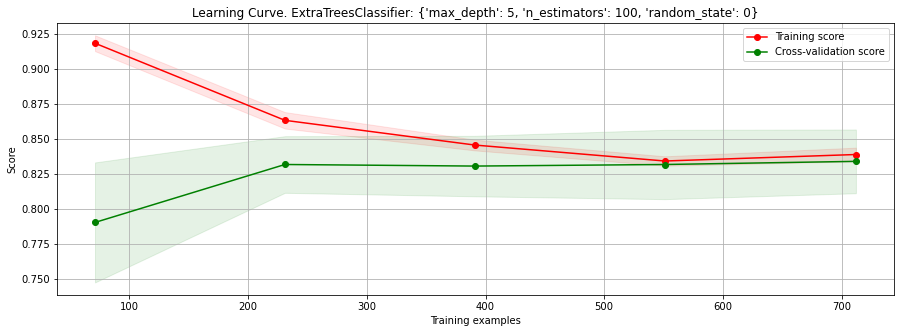

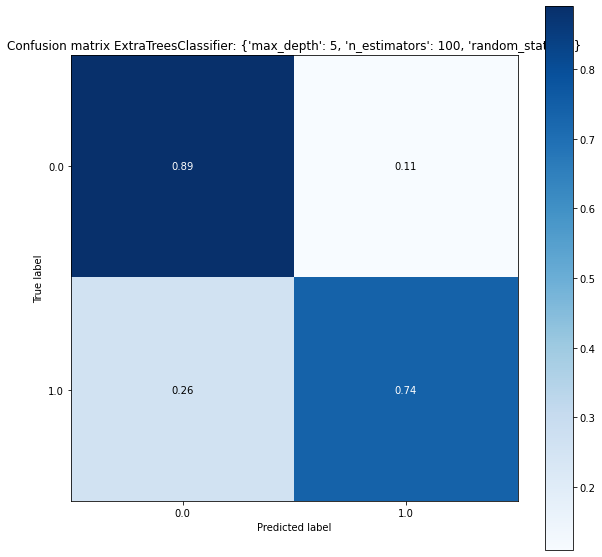

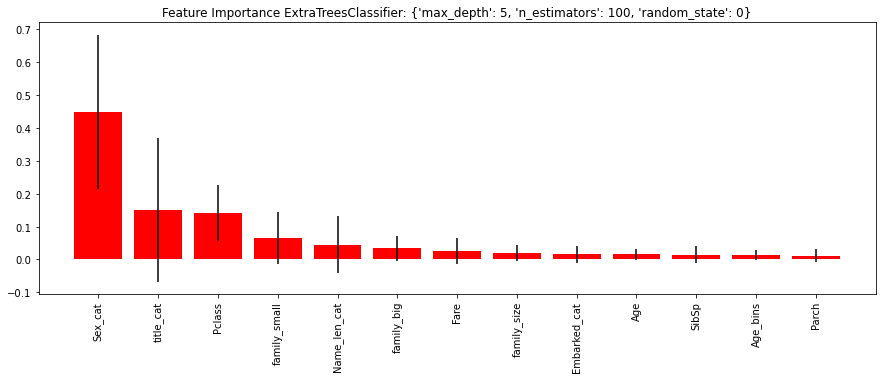

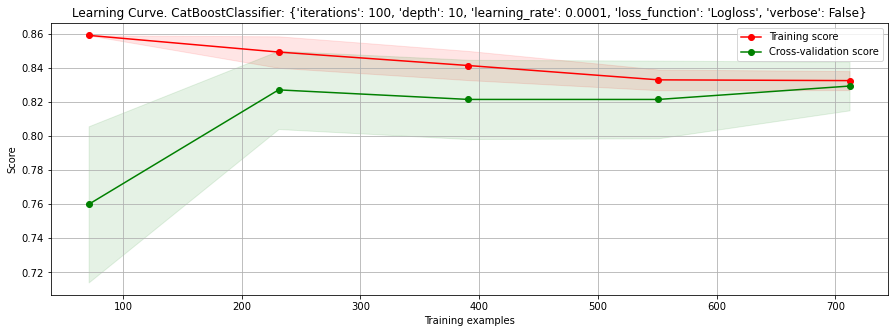

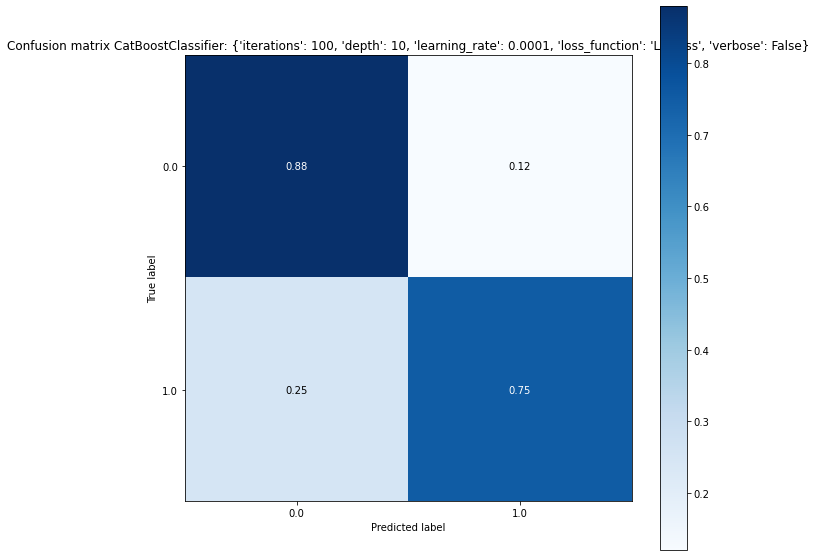

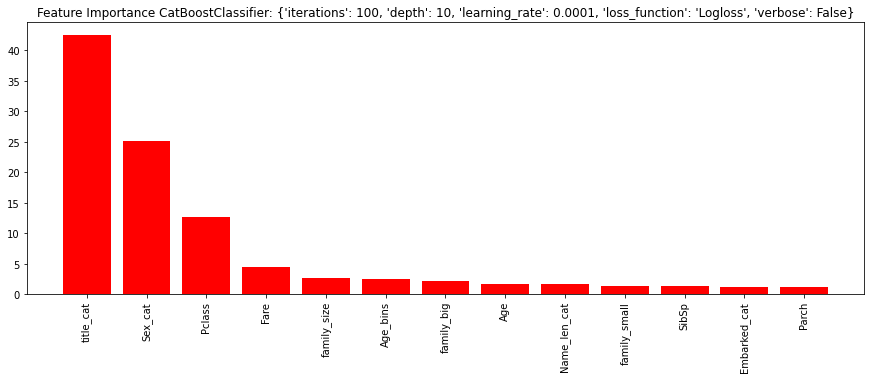

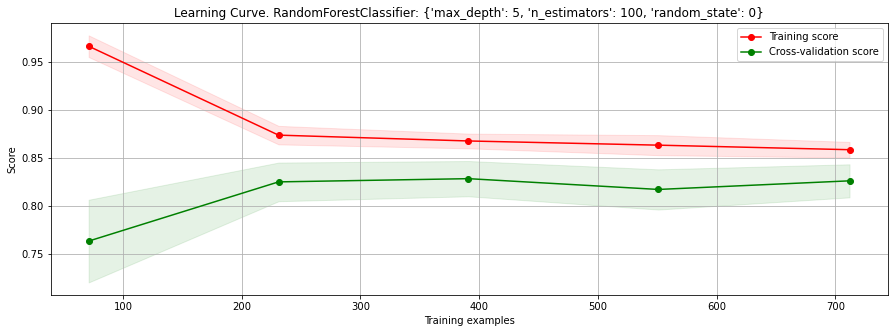

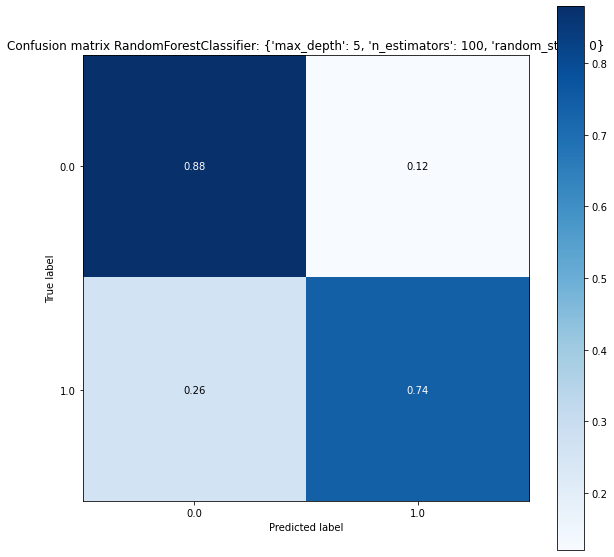

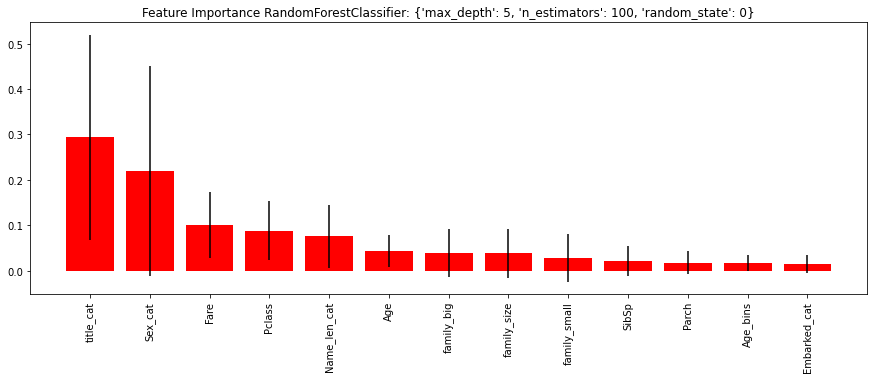

In [214]:
models = \
    [(ExtraTreesClassifier,{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}),
    (ctb.CatBoostClassifier, {'iterations' :100,'depth' :10, 'learning_rate' :0.0001,
                            'loss_function' :'Logloss','verbose' : False}),
    (RandomForestClassifier,{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}),
    ]

scores = eval_models(X_train.drop(['PassengerId'],axis=1).values,y_train.values,cv=5,
                     feats=X_train.drop(['PassengerId'],axis=1).columns,plt_learn_curve_b=True
                     ,plt_confusion_matrix_b=True,plt_feats_importance_b=True) #droping ids not to treat it as feature

Ensemble classifiers with two different methods of making decisions

In [218]:
def y_pred_vote(y_pred_list):
    """
    Decision made by each of the classifier is multiplied
    with survived being 1 and dead 0. 
    That way i try to shift bias slightly toward survival
    """
    y_pred_tuple_maped = [x for x in map(np.vectorize({0:-1,1:1}.get),y_pred_list)]
    return np.array([1 if sum(x)>=0 else 0 for x in np.column_stack(y_pred_tuple_maped)])
    
def y_pred_multi(y_pred_list):
    """
    Decision made by each of the classifier is multiplied
    with survived being 1 and dead 0. 
    That way i try to shift bias slightly toward survival
    """
    ensemble_pred = np.ones(shape=(len(y_pred_list[0])),dtype=bool)
    for y_pred in y_pred_list:
        ensemble_pred = ensemble_pred * ~y_pred.astype(bool)
    return ~ensemble_pred

def learn_ensemble(X,y,df,models,decision_strat,n_folds=5,plot_heat=False):
    scores = []
    for train_index, test_index in KFold(n_folds).split(X):
        X_train, X_test = X[train_index], X[test_index]        
        y_train, y_test = y[train_index], y[test_index]
        y_pred_list = []
        for model_cls,model_args in models:
            model = model_cls(**model_args)
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            y_pred_list.append(y_pred)
        
        score = accuracy_score(y_test.astype(bool),decision_strat(y_pred_list))
        scores.append(score)
    
    #test_df = df.iloc[test_index]
    #display(test_df[y_test.astype(bool)!=decision_strat(y_pred_list)])
    if plot_heat:
        skplt.metrics.plot_confusion_matrix(y_test.astype(bool),decision_strat(y_pred_list),
                                        normalize=True, figsize=(7 ,5))
    
    #display([y_test.astype(bool) != decision_strat(y_pred_list)])
    return scores,np.mean(scores)

Decision based on matrices multiplication

In [219]:
scores,np_mean_scores = learn_ensemble(X_train.drop(['PassengerId'],axis=1).values,
                                       y_train.values,train_test_df,models,decision_strat=y_pred_multi,n_folds=5)
print(scores,np_mean_scores)

[0.8379888268156425, 0.8258426966292135, 0.8202247191011236, 0.797752808988764, 0.8539325842696629] 0.8271483271608814


Voting decision

([0.8491620111731844,
  0.8258426966292135,
  0.8202247191011236,
  0.797752808988764,
  0.8651685393258427],
 0.8316301550436256)

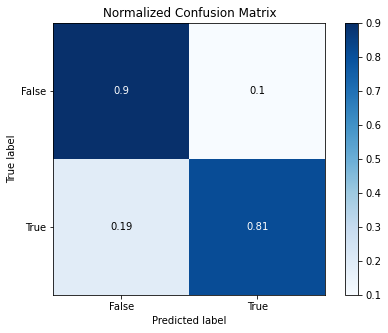

In [220]:
learn_ensemble(X_train.drop(['PassengerId'],axis=1).values,
                                       y_train.values,train_test_df ,models,decision_strat=y_pred_vote,n_folds=5,plot_heat=True)

The highest ensemble score **83.16%** is lower than the highest score of the ExtraTreesClassifier on its own **83.39**.  But ensemble helped to correctly detect more people who survived, that is why ensemble might be usefull in the future

# Hyperparameters tuning
With ExtraTrees reaching the highest accuracy I will tune this model hyperparameters, to get even greater accuracy

In [ ]:
def objective_ExtraTrees_Classifier(space):
    
    ExtraTrees_params = {
        'max_depth':  space['max_depth'],
        'n_estimators': int(space['n_estimators']),
        'min_weight_fraction_leaf': space['min_weight_fraction_leaf'],
        'random_state': int(space['random_state']),
        'min_impurity_decrease' : space['min_impurity_decrease'],
        'max_features': int(space['max_features']),
        #'min_samples_split': space['min_samples_split'],
        #'min_samples_leaf': space['min_samples_leaf'],
    }
    scores = cross_val_score(ExtraTreesClassifier(**ExtraTrees_params), X, y, cv=5, scoring='accuracy');
    return{'loss':-np.mean(scores), 'status': STATUS_OK }
    
X,y = get_cat_feats(train_test_df,id_range=(0,X_test_min_id))
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
space ={
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'max_depth':  hp.quniform ('max_depth', 1, 20, 1),
    'n_estimators': hp.quniform('n_estimators', 50,250,15),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf',0.0, 0.5),
    'random_state': hp.quniform('random_state', 0, 1000, 50),
    'min_impurity_decrease' : hp.uniform('min_impurity_decrease',0.0, 5),
    'max_features': hp.quniform('max_features', 1, 14, 1),
    #'min_samples_split': hp.uniform('min_samples_split', 0.0,0.5),
    #'min_samples_leaf': hp.uniform('min_samples_leaf', 0.0,0.5)

}
trials = Trials()
best_params = fmin(fn=objective_ExtraTrees_Classifier,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=30),
            max_evals=200,
            trials=trials)
print("The best params: ", best_params)

ExtraTreesClassifier mean = 80.92 st_dev = 0.01 scores = [0.79888268 0.81460674 0.82022472 0.78651685 0.8258427 ]


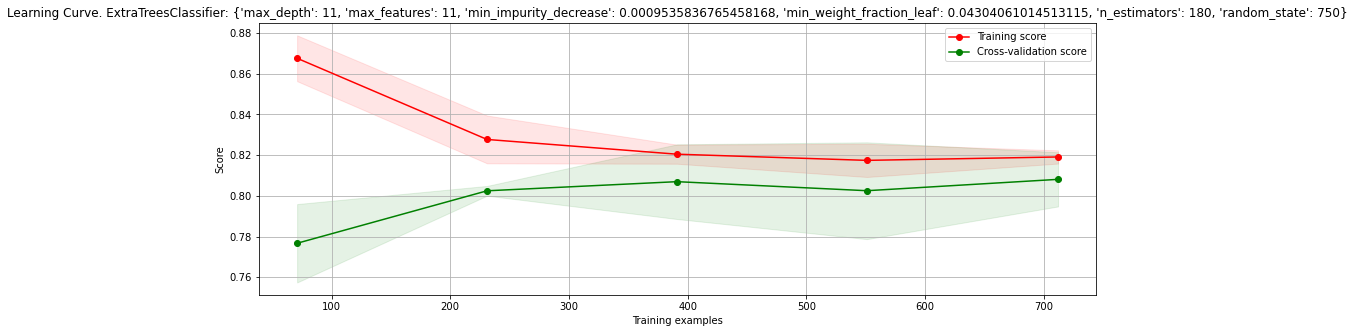

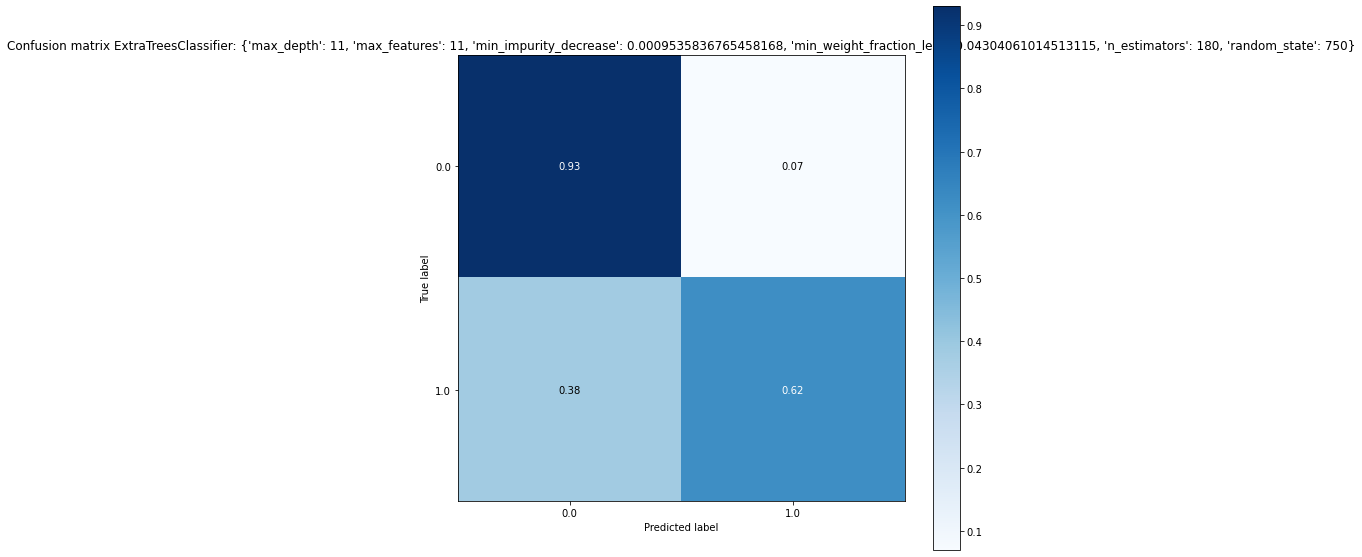

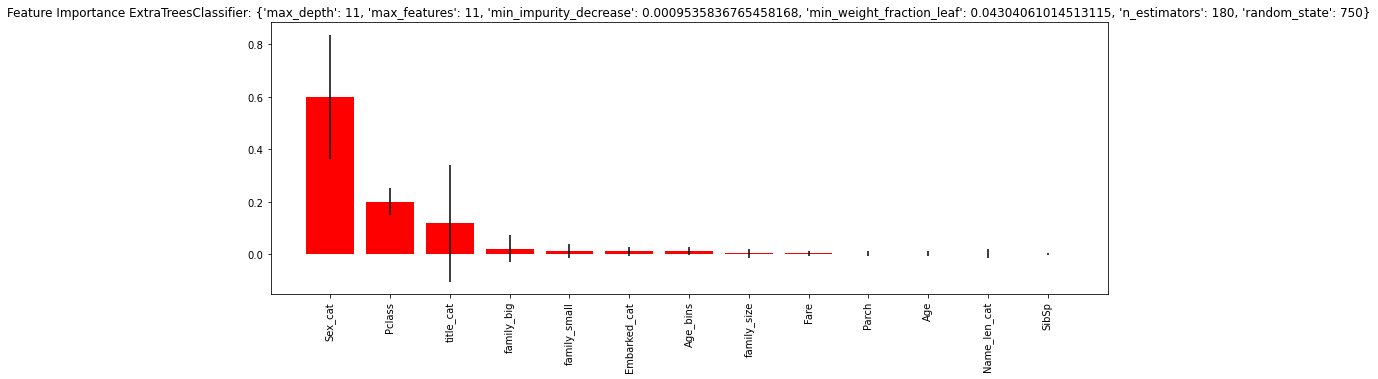

In [222]:
models = \
    [(ExtraTreesClassifier,{'max_depth': 11, 'max_features': 11,
                            'min_impurity_decrease': 0.0009535836765458168,
                            'min_weight_fraction_leaf': 0.04304061014513115, 'n_estimators': 180, 'random_state': 750})
    ]
X,y = get_cat_feats(train_test_df,id_range=(0,X_test_min_id))
scores = eval_models(X.drop(['PassengerId'],axis=1).values,y.values,cv=5,
                     feats=X.drop(['PassengerId'],axis=1).columns,plt_learn_curve_b=True
                     ,plt_confusion_matrix_b=True,plt_feats_importance_b=True) #droping ids not to treat it as feature

We can see that class 0 (dead) is much better supported than class 1 (survivors), this disproportion may be caused by not balanced observations per class, there were more dead than alive after titanic sunk. Also sex seems to be te most important category. It was suspecte due to much greater survival rate in the case of woman.

I am tuning CatBoost as well

In [ ]:
def objective_ctb(space):
    
    params = {
    'learning_rate': space['learning_rate'],
    'max_depth': space['max_depth'],
    'colsample_bylevel': space['colsample_bylevel'],
    'bagging_temperature': space['bagging_temperature'],
    'random_strength': space['random_strength'],
    'scale_pos_weight': space['scale_pos_weight'], # change 16.0 to n_negative / n_poistive
    'verbose': False
    }
    
    scores = cross_val_score(ctb.CatBoostClassifier(**params), X, y, cv=5, scoring='accuracy');
    return{'loss':-np.mean(scores), 'status': STATUS_OK }
    
X,y = get_cat_feats(train_test_df,id_range=(0,X_test_min_id))
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.8),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 100),
    'random_strength': hp.uniform('random_strength', 0.0, 100),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.0, 16.0), # change 16.0 to n_negative / n_poistive
}
trials = Trials()
best_params = fmin(fn=objective_ctb,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=200,
            trials=trials)
#print("The best params: ", best_params)

In [95]:
best_params

{'bagging_temperature': 32.05834548490316,
 'colsample_bylevel': 0.570612371830504,
 'learning_rate': 0.1801940638608459,
 'max_depth': 9.0,
 'random_strength': 66.56656771099416,
 'scale_pos_weight': 2.6527058264485546}

In [ ]:
models = \
    [(ctb.CatBoostClassifier, best_params)]
X,y = get_cat_feats(train_test_df,id_range=(0,X_test_min_id))
scores = eval_models(X.drop(['PassengerId'],axis=1).values,y.values,cv=5,
                     feats=X.drop(['PassengerId'],axis=1).columns,plt_learn_curve_b=False
                     ,plt_confusion_matrix_b=False,plt_feats_importance_b=False) 

It seems that after hyperparameter tuning I was not able to reach higher score than with my parameters. 
I will check both hypertuned models and my previous attempts on through kaggle submission

# Kaggle submission

In [128]:
def get_numerical_test(df,id_range):
    start,stop = id_range
    numerical_cols = [column for column in df.columns 
                  if df[column].dtype != np.dtype(object) and column != ('Survived')]    
    in_id_range = ((df['PassengerId']>=start) & (df['PassengerId']<stop))
    
    X_train = df[in_id_range][numerical_cols].fillna(-1)
    y_train = df[in_id_range]['Survived']
    
    in_id_range = (df['PassengerId']>=stop)
    X_test = df[in_id_range][numerical_cols].fillna(-1)
    
    return X_train,y_train,X_test

In [174]:
X_train,y_train,X_test = get_numerical_test(train_test_df,id_range=(0,X_test_min_id))

models = \
    [(ExtraTreesClassifier,{'max_depth': 5, 'n_estimators': 100, 'random_state': 0}), # my params 
    (ctb.CatBoostClassifier, {'verbose' :False,'iterations' :100,'depth' :10, 'learning_rate' :0.0001, #my params
                            'loss_function' :'Logloss','verbose' : False}),
    (ExtraTreesClassifier,{'max_depth': 11, 'max_features': 11,
                            'min_impurity_decrease': 0.0009535836765458168,
                            'min_weight_fraction_leaf': 0.04304061014513115, 'n_estimators': 180, 'random_state': 750}), # hypertuned
     (ctb.CatBoostClassifier,{'verbose' :False,'bagging_temperature': 32.05834548490316,'colsample_bylevel': 0.570612371830504, 'learning_rate': 0.1801940638608459,
                         'max_depth': 9.0, 'random_strength': 66.56656771099416,'scale_pos_weight': 2.6527058264485546})] #hypertuned 
y_pred_lst = []
for model_cls,params in models:
    model = model_cls(**params)
    model.fit(X_train.drop(['PassengerId'],axis=1).values,y_train.values)
    y_pred = model.predict(X_test.drop(['PassengerId'],axis=1).values)
    y_pred_lst.append((model_cls.__name__,y_pred))

I will also check ensemble models on kaggle

In [175]:
ensemble_vote = ('ensemble_vote',y_pred_vote([y_pred_lst[2][1],y_pred_lst[1][1]]))
ensembl_multi = ('ensemble_multi',y_pred_multi([y_pred_lst[2][1],y_pred_lst[1][1]]))

y_pred_lst.extend([ensemble_vote])
y_pred_lst.extend([ensembl_multi])

In [177]:
for i,x in enumerate(y_pred_lst):
    name, arr = x
    with open(f'../output/{name}_{str(i)}.csv','w') as wr:
        ind = X_test_min_id
        wr.write(','.join(['PassengerId','Survived'])+'\n')
        for pred in arr:
            wr.write(','.join([str(ind),str(int(pred))])+'\n')
            ind+=1


On kaggle i got 78.947 % accuracy which placed me in first 11% of the participants (https://www.kaggle.com/c/titanic/leaderboard#score)  
The best submission was ExtraTreesClassifier after hypertuning